In [1]:
import numpy as np
import pandas as pd

In [2]:
import re
import string
import shutil
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, GlobalMaxPooling1D, Conv1D, Dropout, TextVectorization
from tensorflow.keras.losses import BinaryCrossentropy
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [4]:
train = pd.read_csv(r"C:\Users\acer\disasterTweets\input\nlp-getting-started/train.csv")
test = pd.read_csv(r"C:\Users\acer\disasterTweets\input\nlp-getting-started/test.csv")
sample_submission = pd.read_csv(r"C:\Users\acer\disasterTweets\input\nlp-getting-started/sample_submission.csv")

In [5]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [8]:
print(f"train shape {train.shape}")
print(f"test shape {test.shape}")

train shape (7613, 5)
test shape (3263, 4)


In [9]:
train.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [11]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [12]:
train.keyword.value_counts().to_frame()

,keyword
fatalities,45
deluge,42
armageddon,42
sinking,41
damage,41
...,...
forest%20fire,19
epicentre,12
threat,11
inundation,10


In [13]:
train.location.value_counts().to_frame()

,location
USA,104
New York,71
United States,50
London,45
Canada,29
...,...
"MontrÌ©al, QuÌ©bec",1
Montreal,1
"ÌÏT: 6.4682,3.18287",1
Live4Heed??,1


In [14]:
train.target.value_counts().to_frame()

,target
0,4342
1,3271


In [15]:
def custom_tokenize(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    stripped_hyperlink = tf.strings.regex_replace(stripped_html, 'https?://\S+|www\.\S+', '')
    stripped_square_brackets = tf.strings.regex_replace(stripped_hyperlink, '\[.*?\]', '')
    stripped_punctuation = tf.strings.regex_replace(stripped_square_brackets, '[%s]' % re.escape(string.punctuation), '')
    stripped_punctuation = tf.strings.regex_replace(stripped_punctuation, '\n', '')
    stripped_number = tf.strings.regex_replace(stripped_punctuation, '\w*\d\w*', '')
    
    return tf.strings.regex_replace(stripped_number, '[%s]' % re.escape(string.punctuation), '')

In [16]:
train['text'] = custom_tokenize(train['text'])

In [17]:
#hyperParam
max_features = 100000
sequence_length = 500

In [18]:
vectorize_layer = TextVectorization(
                    standardize = custom_tokenize,
                    max_tokens = max_features,
                    output_mode = 'int',
                    output_sequence_length=sequence_length)

In [19]:
train['text'].values

array([b'our deeds are the reason of this earthquake may allah forgive us all',
       b'forest fire near la ronge sask canada',
       b'all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected',
       ..., b'  s of volcano hawaii ',
       b'police investigating after an ebike collided with a car in little portugal ebike rider suffered serious nonlife threatening injuries',
       b'the latest more homes razed by northern california wildfire  abc news '],
      dtype=object)

In [20]:
vectorize_layer.adapt(train['text'].values)

In [21]:
vectorize_text = vectorize_layer(train['text'].values)
vectorize_text

<tf.Tensor: shape=(7613, 500), dtype=int64, numpy=
array([[ 108, 5945,   22, ...,    0,    0,    0],
       [ 176,   44,  210, ...,    0,    0,    0],
       [  40, 1671, 1625, ...,    0,    0,    0],
       ...,
       [ 209,    6,  540, ...,    0,    0,    0],
       [  76, 1057,   38, ...,    0,    0,    0],
       [   2,  193,   52, ...,    0,    0,    0]], dtype=int64)>

In [22]:
Xs = vectorize_text
y = train['target']

In [23]:
#hyperparam
embedding_dim = 32
filters = 128
kernel_size = 5
dense_dim = 64

In [24]:
model = Sequential([
    Embedding(max_features + 1, embedding_dim),
    Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(dense_dim, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          3200032   
                                                                 
 conv1d (Conv1D)             (None, None, 128)         20608     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                        

In [26]:
NUM_EPOCHS = 15

In [27]:
history = model.fit(Xs, y, epochs=NUM_EPOCHS)

Epoch 1/15
238/238 [==============================] - 26s 94ms/step - loss: 0.5533 - accuracy: 0.7114
Epoch 2/15
238/238 [==============================] - 22s 92ms/step - loss: 0.3180 - accuracy: 0.8725
Epoch 3/15
238/238 [==============================] - 21s 89ms/step - loss: 0.1767 - accuracy: 0.9415
Epoch 4/15
238/238 [==============================] - 23s 98ms/step - loss: 0.1033 - accuracy: 0.9670
Epoch 5/15
238/238 [==============================] - 18s 77ms/step - loss: 0.0780 - accuracy: 0.9753
Epoch 6/15
238/238 [==============================] - 19s 79ms/step - loss: 0.0663 - accuracy: 0.9798
Epoch 7/15
238/238 [==============================] - 19s 78ms/step - loss: 0.0552 - accuracy: 0.9807
Epoch 8/15
238/238 [==============================] - 18s 76ms/step - loss: 0.0482 - accuracy: 0.9820
Epoch 9/15
238/238 [==============================] - 19s 79ms/step - loss: 0.0418 - accuracy: 0.9828
Epoch 10/15
238/238 [==============================] - 18s 77ms/step - loss: 0.038

In [28]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy'])

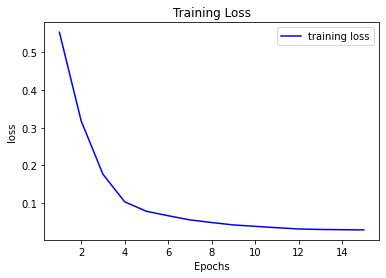

In [29]:
acc = history_dict['accuracy']
loss = history_dict['loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'b', label='training loss')

plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()

plt.show()

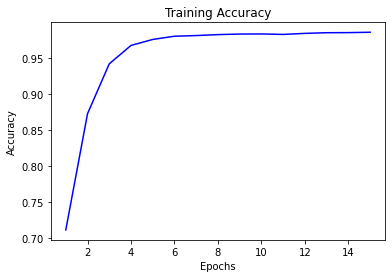

In [30]:
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs, acc, 'b', label='training accuracy')

In [31]:
test['text'] = custom_tokenize(test['text'])

In [47]:
import random

random_num = random.randint(0, (3263-1))

data = test['text'][random_num]

input_data = vectorize_layer(data)

predictions = model.predict(np.expand_dims(input_data, 0))

print(data)
print(predictions)

b'  reddit will now quarantine offensive content wired tech   '
[[0.01355031]]


In [48]:
value = predictions[0][0]
value > 0.5

False

In [49]:
if value>0.5 or value == 0.5:
    print('Disaster Tweets')
elif value < 0.5:
    print('Not a Disaster Tweets')

Not a Disaster Tweets
